In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("Loading dataset...")
data = pd.read_csv("India Agriculture Crop Production.csv")

print(f"Dataset shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")

# Drop rows with missing values
data = data.dropna()
print(f"Dataset shape after dropping missing values: {data.shape}")

# Encode categorical variables
print("Encoding categorical variables...")
le_state = LabelEncoder()
le_district = LabelEncoder()
le_season = LabelEncoder()
le_crop = LabelEncoder()

data['State_encoded'] = le_state.fit_transform(data['State'])
data['District_encoded'] = le_district.fit_transform(data['District'])
data['Season_encoded'] = le_season.fit_transform(data['Season'])
data['Crop_encoded'] = le_crop.fit_transform(data['Crop'])

# Print classes for reference
print(f"Number of states: {len(le_state.classes_)}")
print(f"Number of districts: {len(le_district.classes_)}")
print(f"Number of seasons: {len(le_season.classes_)}")
print(f"Seasons: {le_season.classes_}")
print(f"Number of crops: {len(le_crop.classes_)}")
print(f"Top 10 crops: {le_crop.classes_[:10]}")

# Create mappings for later reference
state_mapping = dict(zip(le_state.transform(le_state.classes_), le_state.classes_))
district_mapping = dict(zip(le_district.transform(le_district.classes_), le_district.classes_))
season_mapping = dict(zip(le_season.transform(le_season.classes_), le_season.classes_))
crop_mapping = dict(zip(le_crop.transform(le_crop.classes_), le_crop.classes_))

# Standardize numerical features
scaler = StandardScaler()
data['Area_scaled'] = scaler.fit_transform(data[['Area']])

# Add interaction terms
print("Creating interaction terms...")
data['State_District'] = data['State_encoded'] * data['District_encoded']
data['State_Season'] = data['State_encoded'] * data['Season_encoded']
data['District_Season'] = data['District_encoded'] * data['Season_encoded']

# Calculate average yield for each combination
print("Calculating average yields...")
avg_yield = data.groupby(['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded'])['Yield'].mean().reset_index()
avg_yield.rename(columns={'Yield': 'Avg_Yield'}, inplace=True)

# Merge with main data
data = pd.merge(data, avg_yield, on=['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded'], how='left')
data['Avg_Yield'].fillna(data['Yield'].mean(), inplace=True)

# Prepare features and target for training
X = data[['State_encoded', 'District_encoded', 'Season_encoded', 'Crop_encoded', 
          'Area_scaled', 'State_District', 'State_Season', 'District_Season', 'Avg_Yield']]
y = data['Yield']

# Create column names for better interpretation
X.columns = ['State', 'District', 'Season', 'Crop', 'Area', 'State_District', 'State_Season', 'District_Season', 'Avg_Yield']

# Split data for training and testing
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor with careful hyperparameter tuning
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'subsample': [0.8, 1.0]
}

# Perform randomized search
print("Performing hyperparameter tuning...")
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")

# Get the best model
tuned_model = random_search.best_estimator_

# Evaluate on test data
print("Evaluating model...")
y_pred = tuned_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# Calculate feature importance
print("Feature importance:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tuned_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

# Save feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# Function to test the model with specific inputs
def test_prediction(state, district, season, area=10.0):
    try:
        # Encode inputs
        state_encoded = le_state.transform([state])[0]
        district_encoded = le_district.transform([district])[0]
        season_encoded = le_season.transform([season])[0]
        area_scaled = scaler.transform([[area]])[0][0]
        
        # Calculate interaction terms
        state_district = state_encoded * district_encoded
        state_season = state_encoded * season_encoded
        district_season = district_encoded * season_encoded
        
        # Get all crops
        all_crops = []
        for crop_name, crop_code in zip(le_crop.classes_, le_crop.transform(le_crop.classes_)):
            # Get average yield
            avg_yield_value = data[
                (data['State_encoded'] == state_encoded) &
                (data['District_encoded'] == district_encoded) &
                (data['Season_encoded'] == season_encoded) &
                (data['Crop_encoded'] == crop_code)
            ]['Avg_Yield'].mean()
            
            # Use overall average if no data exists
            if np.isnan(avg_yield_value):
                avg_yield_value = data['Avg_Yield'].mean()
            
            # Create feature vector
            features = np.array([
                [state_encoded, district_encoded, season_encoded, crop_code,
                 area_scaled, state_district, state_season, district_season, avg_yield_value]
            ])
            
            # Predict yield
            predicted_yield = tuned_model.predict(features)[0]
            all_crops.append((crop_name, predicted_yield))
        
        # Sort by yield and get top 5
        all_crops.sort(key=lambda x: x[1], reverse=True)
        return all_crops[:5]
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return []

# Test the model with Karnataka DHARWAD Rabi
print("\nTesting model with Karnataka DHARWAD Rabi:")
test_results = test_prediction("Karnataka", "DHARWAD", "Rabi")
print(f"Top 5 Recommended Crops for Karnataka, DHARWAD, Rabi Season:")
for crop, yield_value in test_results:
    print(f"{crop}: {yield_value:.2f} tonnes/hectare")

# Test with another location
print("\nTesting model with Tamil Nadu, CHENNAI, Kharif:")
test_results = test_prediction("Tamil Nadu", "CHENNAI", "Kharif")
print(f"Top 5 Recommended Crops for Tamil Nadu, CHENNAI, Kharif Season:")
for crop, yield_value in test_results:
    print(f"{crop}: {yield_value:.2f} tonnes/hectare")

# Save the model with all required artifacts
print("\nSaving model...")
model_artifacts = {
    'model': tuned_model,
    'le_state': le_state,
    'le_district': le_district,
    'le_season': le_season,
    'le_crop': le_crop,
    'scaler': scaler,
    'state_mapping': state_mapping,
    'district_mapping': district_mapping,
    'season_mapping': season_mapping,
    'crop_mapping': crop_mapping,
    'feature_names': X.columns.tolist()
}

# Set path to project directory
project_path = '/Users/vvmohith/Desktop/OOAD-proj'
target_path = os.path.join(project_path, 'crop_recommendation_model.pkl')

# Save the model
joblib.dump(model_artifacts, target_path)
print(f"Model saved to: {target_path}")

# Also save to Spring Boot resources
spring_target_path = '/Users/vvmohith/Desktop/OOAD-proj/smart-crop-advisor/src/main/resources/model/crop_recommendation_model.pkl'
os.makedirs(os.path.dirname(spring_target_path), exist_ok=True)
joblib.dump(model_artifacts, spring_target_path)
print(f"Model also saved to: {spring_target_path}")

Loading dataset...
Dataset shape: (345407, 10)
Missing values: 5092
Dataset shape after dropping missing values: (340414, 10)
Encoding categorical variables...
Number of states: 36
Number of districts: 728
Number of seasons: 6
Seasons: ['Autumn' 'Kharif' 'Rabi' 'Summer' 'Whole Year' 'Winter']
Number of crops: 56
Top 10 crops: ['Arecanut' 'Arhar/Tur' 'Bajra' 'Banana' 'Barley' 'Black pepper'
 'Cardamom' 'Cashewnut' 'Castor seed' 'Coconut']
Creating interaction terms...
Calculating average yields...
Splitting data into train and test sets...
Training Gradient Boosting model...
Performing hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.05}
Evaluating model...
Mean Squared Error: 84420.50
R² Score: 0.8951
Feature importance:
           Feature    Importance
8        Avg_Yield  9.638567e-01
4             Area  3.145500e-02
7  District_Seaso


--- TESTING MORE EXAMPLES ---

Testing: Karnataka BALLARI Rabi
Top 5 Recommended Crops for Karnataka, BALLARI, Rabi Season:
Turmeric: 88.82 tonnes/hectare
other oilseeds: 88.82 tonnes/hectare
Arecanut: 77.02 tonnes/hectare
Arhar/Tur: 77.02 tonnes/hectare
Bajra: 77.02 tonnes/hectare

Testing: Maharashtra PUNE Kharif
Top 5 Recommended Crops for Maharashtra, PUNE, Kharif Season:
Turmeric: 88.82 tonnes/hectare
Wheat: 88.82 tonnes/hectare
Arecanut: 77.02 tonnes/hectare
Banana: 77.02 tonnes/hectare
Barley: 77.02 tonnes/hectare

Testing: Andhra Pradesh ANANTAPUR Whole Year
Top 5 Recommended Crops for Andhra Pradesh, ANANTAPUR, Whole Year Season:
Coconut: 15677.26 tonnes/hectare
Urad: 88.82 tonnes/hectare
Wheat: 88.82 tonnes/hectare
other oilseeds: 88.82 tonnes/hectare
Sugarcane: 86.89 tonnes/hectare

Testing: Uttar Pradesh AGRA Rabi
Top 5 Recommended Crops for Uttar Pradesh, AGRA, Rabi Season:
other oilseeds: 88.82 tonnes/hectare
Arecanut: 77.02 tonnes/hectare
Arhar/Tur: 77.02 tonnes/hectare

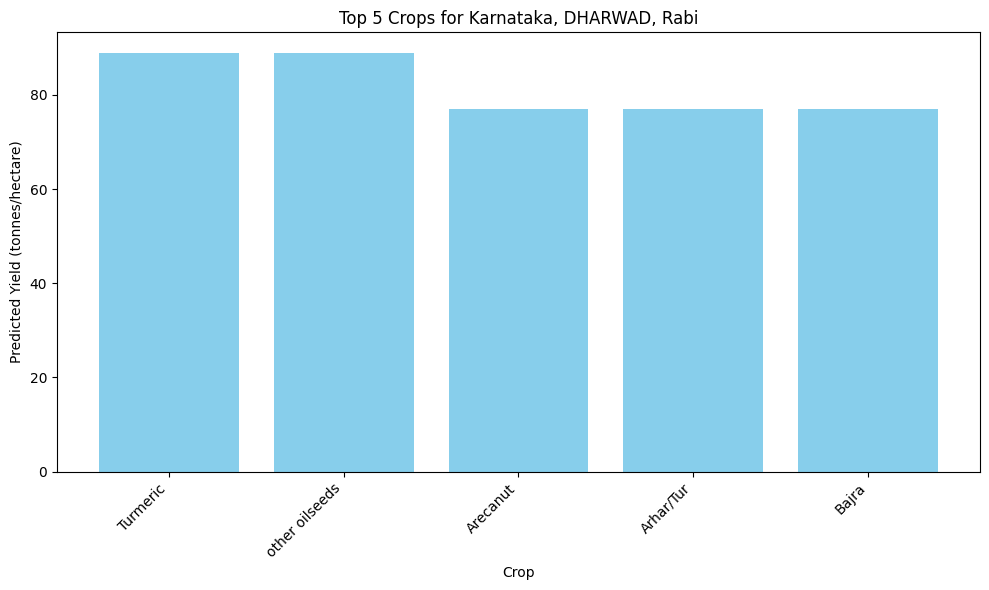

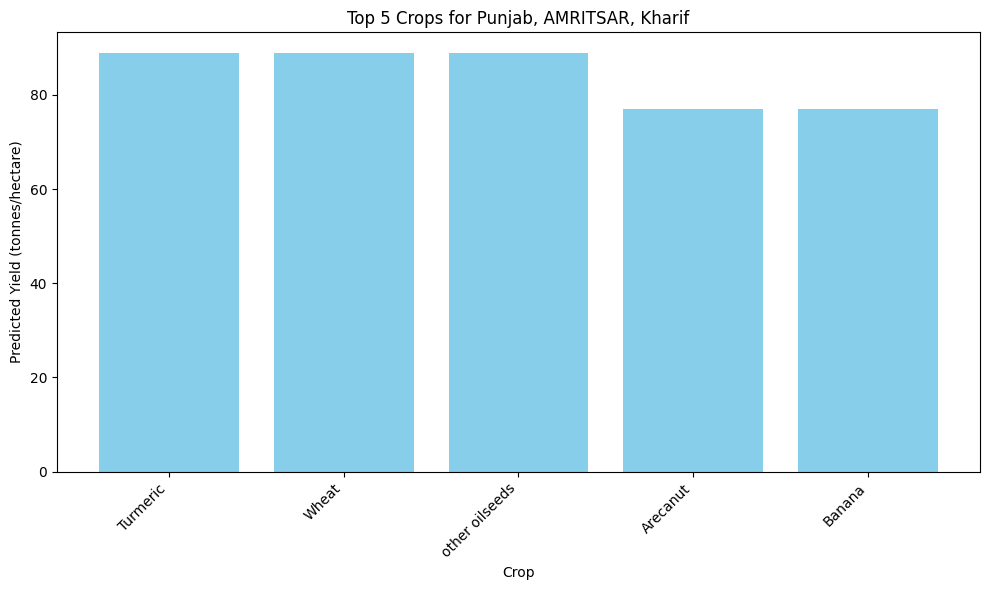

In [2]:
# Test with more examples
print("\n--- TESTING MORE EXAMPLES ---")

# Test cases for different regions and seasons
test_cases = [
    ("Karnataka", "BALLARI", "Rabi", "Karnataka BALLARI Rabi"),
    ("Maharashtra", "PUNE", "Kharif", "Maharashtra PUNE Kharif"),
    ("Andhra Pradesh", "ANANTAPUR", "Whole Year", "Andhra Pradesh ANANTAPUR Whole Year"),
    ("Uttar Pradesh", "AGRA", "Rabi", "Uttar Pradesh AGRA Rabi"),
    ("Punjab", "AMRITSAR", "Kharif", "Punjab AMRITSAR Kharif")
]

# Test each case
for state, district, season, description in test_cases:
    try:
        print(f"\nTesting: {description}")
        results = test_prediction(state, district, season)
        print(f"Top 5 Recommended Crops for {state}, {district}, {season} Season:")
        for crop, yield_value in results:
            print(f"{crop}: {yield_value:.2f} tonnes/hectare")
    except Exception as e:
        print(f"Error testing {description}: {str(e)}")

# Create a function to visualize predictions for a specific location
def visualize_predictions(state, district, season, area=10.0):
    results = test_prediction(state, district, season, area)
    if not results:
        print(f"No results for {state}, {district}, {season}")
        return
    
    # Extract crop names and yields
    crops = [crop for crop, _ in results]
    yields = [yield_val for _, yield_val in results]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(crops, yields, color='skyblue')
    plt.xlabel('Crop')
    plt.ylabel('Predicted Yield (tonnes/hectare)')
    plt.title(f'Top 5 Crops for {state}, {district}, {season}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Visualize a few test cases
print("\nVisualizing selected test cases...")
visualize_predictions("Karnataka", "DHARWAD", "Rabi")
visualize_predictions("Punjab", "AMRITSAR", "Kharif")